# Data exploratory analysis

The goal of this notebook is to explore the data and identify potential interesting insights

In [4]:
import pandas as pd
import numpy as np

# Statistics + plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## 1. Import data

In [5]:
# Open categories.cvs
categories = pd.read_csv('../project-4/data/clean-data/categories-post.csv')

# Explore data
categories.head()

,Unnamed: 0,Category,Sub-category,Keyword,Search Vol (min),Search Vol (max),Number of templates
0,0,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145
1,1,Video,Social Feed Video Ad,Social Feed Video Ad template,2.307692,23.076923,159
2,2,Video,Pinterest Video Pin,Pinterest Video Pin template,2.307692,23.076923,21
3,3,Video,In-Stream Video Ad,In-Stream Video Ad template,2.307692,23.076923,149
4,4,Video,Youtube Intro,Youtube Intro template,230.769231,2307.692308,126


In [6]:
# Open .csv with Search trends and store them into a list of dics

csv_names = []
trends = {}

# Replace ' ' for '-'
for sub in categories['Sub-category']:
    csv_names.append(sub.replace(' ', '-').lower())
    
# Import .csv files
for name, sub in zip(csv_names, categories['Sub-category']):
    trends.update({sub: pd.read_csv(f'../project-4/data/clean-data/{name}.csv')})
    trends[sub].drop('Unnamed: 0', axis=1, inplace=True)
    
# Explore the data
trends['Instagram Ad']

,Date,Trend,isPartial,Category,Sub-category,Keyword,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge),Search Vol
0,2015-07-12,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,0.000000
1,2015-07-19,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,0.000000
2,2015-07-26,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,0.000000
3,2015-08-02,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,0.000000
4,2015-08-09,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
256,2020-06-07,20,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,461.538462
257,2020-06-14,20,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,461.538462
258,2020-06-21,31,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,715.384615
259,2020-06-28,42,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,969.230769


## 2. Merging tables for the analysis

In [7]:
for sub in trends:
    try:
        trends[sub]['Date'] = pd.to_datetime(trends[sub]['Date'])
    except:
        pass

## 3. Basic plotting

### 3.1 Search volume evolution

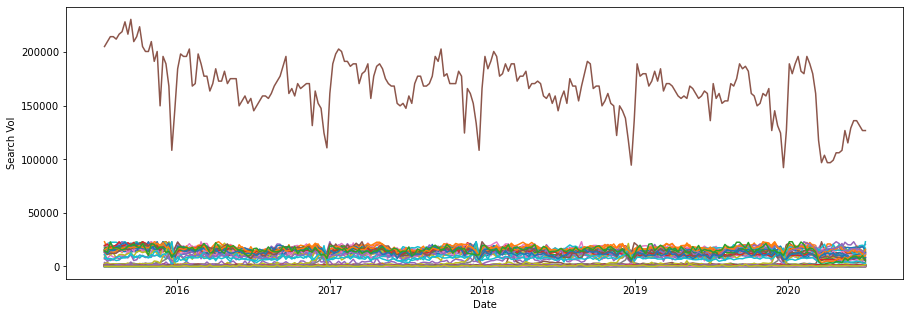

In [8]:
# Volume of searchs
plt.figure(figsize=(15,5))

for sub in trends:
    try:
    # Create a graph with the volume of searches
        ax = sns.lineplot(data=trends[sub], 
                          x='Date', 
                          y='Search Vol')
    except:
        pass

'Resume' sub-categorie has much more search vol than the rest. For the sake of the analysis, could be interesting to add some sub-categories.

In [9]:
# Same plot with subcategories with less than 10.000 monthly searches on average
trends_gp = {'Under 1k': pd.DataFrame(columns=['Date', 'Search Vol']),
             'Under 10k': pd.DataFrame(columns=['Date', 'Search Vol']),
             'Under 100k': pd.DataFrame(columns=['Date', 'Search Vol'])}

# Aggregate DataFrames by groups depending on Search Vol.
for sub in trends:
    try:
        # Subcategories with an avge of less than 1k monthly seaches
        if (trends[sub]['Search Vol'].mean() < 1000):
            trends_gp['Under 1k'] = pd.concat([trends_gp['Under 1k'], trends[sub]])
        
        # Subcategories with an avge of less than 10k monthly seaches
        elif (trends[sub]['Search Vol'].mean() < 10000):
            trends_gp['Under 10k'] = pd.concat([trends_gp['Under 10k'], trends[sub]])
    
        # Subcategories with an avge of less than 100k monthly seaches
        elif ((trends[sub]['Search Vol'].mean() < 100000) & (trends[sub]['Search Vol'].mean() > 10000)):
            trends_gp['Under 100k'] = pd.concat([trends_gp['Under 100k'], trends[sub]])
            
        # The rest will be analysed individually
        else:
            trends_gp[sub] = trends[sub]

    except:
        pass
    
# Grouping by day and summing 'Seatch Vol.'
trends_gp['Under 1k'] = trends_gp['Under 1k'].groupby('Date', as_index=False).agg('sum')
trends_gp['Under 10k'] = trends_gp['Under 10k'].groupby('Date', as_index=False).agg('sum')
trends_gp['Under 100k'] = trends_gp['Under 100k'].groupby('Date', as_index=False).agg('sum')

In [10]:
# Checking the results
trends_gp['Under 100k'].head()

,Date,Search Vol,Trend,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge)
0,2015-07-12,349384.615385,1514.0,55384.615385,553846.153846,30767.0,304608.0
1,2015-07-19,369230.769231,1600.0,55384.615385,553846.153846,30767.0,304608.0
2,2015-07-26,371076.923077,1608.0,55384.615385,553846.153846,30767.0,304608.0
3,2015-08-02,368307.692308,1596.0,55384.615385,553846.153846,30767.0,304608.0
4,2015-08-09,376384.615385,1631.0,55384.615385,553846.153846,30767.0,304608.0


Now we have a dictionary with a DataFrame that aggregates the subcategories with less than 1k monthly searches as 'Under 1k', less than 10k monthly searches as 'Under 10k', a DataFrame that aggregates the subcategories with less that 100k monthly searches as 'Under 100k' and individual DataFrames for those subcategories with more than 100k monthly searches.

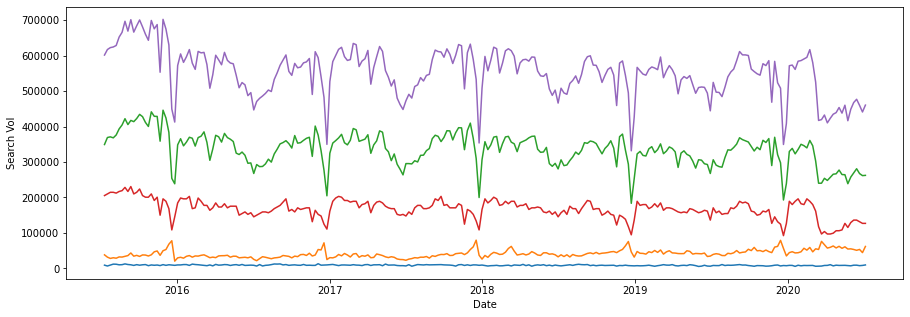

In [66]:
# Plot 
plt.figure(figsize=(15,5))

new_labels = trends_gp.keys()

for sub, key in zip(trends_gp, list_keys):
    # Create a graph with the volume of searches
    ax = sns.lineplot(data=trends_gp[sub], 
                  x='Date', 
                  y='Search Vol')

## [BONUS] - Add legends

It would be useful to list the subcategories in each category.

### 3.2 Search volume aggregated trend

In [67]:
# Combine all searches and find the trend. 
# We will be able to compare each sub_category with the overall trend
# Statistical analysis

In [68]:
trends_gp['Total'] = pd.DataFrame(columns=['Date', 'Search Vol'])

# Concat all DataFrames into one
for sub in trends:
    trends_gp['Total'] = pd.concat([trends_gp['Total'], trends[sub]])

trends_gp['Total'] = trends_gp['Total'].groupby('Date', as_index=False).agg('sum')

#### Calculate the fitted line

In [69]:
# Create a constant
trends_gp['Total'] = sm.add_constant(trends_gp['Total'], has_constant='add')
trends_gp['Total'] = trends_gp['Total'].assign(t=range(1, len(trends_gp['Total']) + 1))
# sub_dic_gp['Total'] = sub_dic_gp['Total'].assign(t2=range(1, (len(sub_dic_gp['Total']) + 1)**2))

In [70]:
# Run OLS
X = trends_gp['Total'][["const", "t"]]
y = trends_gp['Total']["Search Vol"]

lin_reg = sm.OLS(y, X)
results_total = lin_reg.fit()

results_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Search Vol   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     64.97
Date:                Thu, 09 Jul 2020   Prob (F-statistic):           2.81e-14
Time:                        17:19:44   Log-Likelihood:                -3240.5
No. Observations:                 261   AIC:                             6485.
Df Residuals:                     259   BIC:                             6492.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.05e+05   7438.099     81.340      0.000     5.9e+05     6.2e+05
t           -396.7390     49.219     -8.061      0.000    -493.660    -299.818
==============================================================================
Omnibus:                       28.680   Durbin-Watson:                   0.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.424
Skew:                          -0.801   Prob(JB):                     2.03e-08
Kurtosis:                       3.831   Cond. No.                         303.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

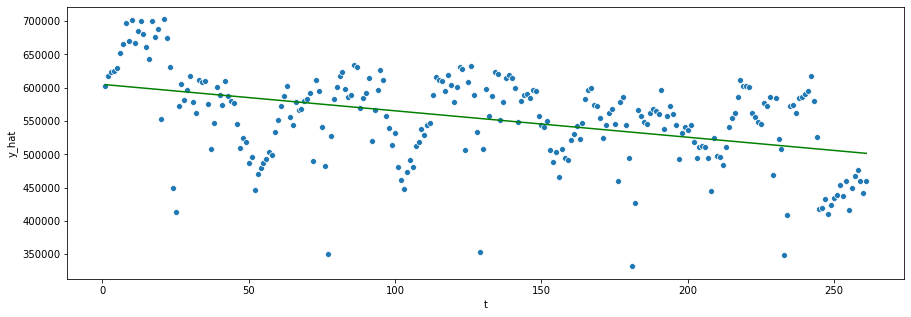

In [71]:
trends_gp['Total'] = trends_gp['Total'].assign(y_hat=results_total.predict(X))

plt.figure(figsize=(15,5))
    
sns.scatterplot(data=trends_gp['Total'], 
                x='t', 
                y='Search Vol');

sns.lineplot(data=trends_gp['Total'],
             x='t',
             y="y_hat",
             color="green");

In [72]:
# Find if there is a correlation between 'Templates' that Canva is offering and 'Search Vol' 
# We will be able to do a linear regression
# Statistical analysis

### 3.3 Search Volume vs. Number of Templates

Is there a correlation between the Search Vol for the Keywords assigned to the category and the number of templates that Canva is offering? Is it statistically significant?

We need to add a column with the Search Vol (avge) to the categories DataFrame

In [73]:
# Add a column with the Search Vol (avge)
categories['Search Vol (mean)'] = (categories['Search Vol (max)'] - categories['Search Vol (min)']) / 2 + categories['Search Vol (min)']

# Bonus, add the Search Vol with the trends

In [74]:
categories.head()

,Unnamed: 0,Category,Sub-category,Keyword,Search Vol (min),Search Vol (max),Number of templates,Search Vol (mean)
0,0,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126.923077
1,1,Video,Social Feed Video Ad,Social Feed Video Ad template,2.307692,23.076923,159,12.692308
2,2,Video,Pinterest Video Pin,Pinterest Video Pin template,2.307692,23.076923,21,12.692308
3,3,Video,In-Stream Video Ad,In-Stream Video Ad template,2.307692,23.076923,149,12.692308
4,4,Video,Youtube Intro,Youtube Intro template,230.769231,2307.692308,126,1269.230769


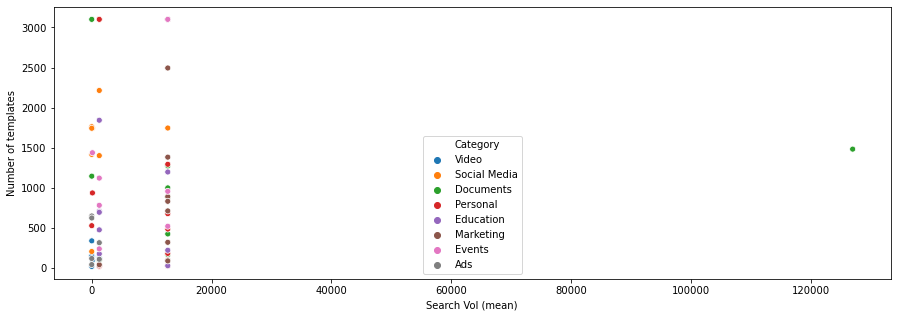

In [75]:
# Scatter plot to infere if it makes sense to calculate the fitted line
plt.figure(figsize=(15,5))
    
sns.scatterplot(data=categories, 
                x='Search Vol (mean)', 
                y='Number of templates',
                hue='Category');

In [76]:
# See if there is a correlation between the two variables
categories = sm.add_constant(categories, has_constant='add')

# Run OLS
lin_reg = sm.OLS(categories["Number of templates"],
                 categories[["const", "Search Vol (mean)"]])

result = lin_reg.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Number of templates   R-squared:                       0.015
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     1.054
Date:                 Thu, 09 Jul 2020   Prob (F-statistic):              0.308
Time:                         17:19:54   Log-Likelihood:                -589.68
No. Observations:                   71   AIC:                             1183.
Df Residuals:                       69   BIC:                             1188.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               952.2590    131.611      7.235      0.000     689.702    1214.816
Search Vol (mean)     0.0078      0.008      1.027      0.308      -0.007       0.023
==============================================================================
Omnibus:                       11.848   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.552
Skew:                           1.070   Prob(JB):                      0.00114
Kurtosis:                       2.957   Cond. No.                     1.93e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [77]:
categories = categories.assign(y_hat=result.predict(categories[["const", "Search Vol (mean)"]]))

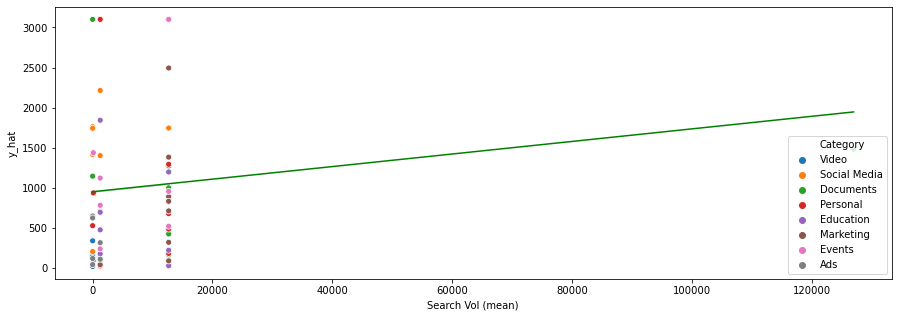

In [78]:
plt.figure(figsize=(15,5))
    
sns.scatterplot(data=categories, 
                x='Search Vol (mean)', 
                y='Number of templates',
                hue='Category');

sns.lineplot(data=categories,
             x='Search Vol (mean)',
             y="y_hat",
             color="g");

Writte CONCLUSION

### 3.3 Search Volume vs. Number of Templates

In [79]:
# Open categories.cvs
trends_all = pd.read_csv('../project-4/data/clean-data/trends-all.csv')

# Explore data

trends_all.drop('Unnamed: 0', axis=1, inplace=True)
trends_all.head()

,Date,Trend,Category,Sub-category,Keyword,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge),Search Vol,isPartial,index
0,2015-07-12,21,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126,48.461538,False,NaN
1,2015-07-19,31,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126,71.538462,False,NaN
2,2015-07-26,20,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126,46.153846,False,NaN
3,2015-08-02,41,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126,94.615385,False,NaN
4,2015-08-09,27,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126,62.307692,False,NaN


In [95]:
# Group by sub-category
trends_all_gp = trends_all.groupby('Sub-category').agg('mean').reset_index(drop=False)
trends_all_gp.head()

,Sub-category,Trend,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge),Search Vol,isPartial,index
0,A4 Document,18.984674,2.307692,23.076923,3100.0,12.0,4.381079,0.003831,NaN
1,Announcement,54.394636,230.769231,2307.692308,1122.0,1269.0,1255.260831,0.003831,NaN
2,Birthday Card,64.172414,2307.692308,23076.923077,679.0,12692.0,14809.018568,0.003831,NaN
3,Birthday Invitation,66.563218,2307.692308,23076.923077,957.0,12692.0,15360.742706,0.003831,NaN
4,Bookmark,50.452107,2307.692308,23076.923077,223.0,12692.0,11642.793988,0.003831,NaN


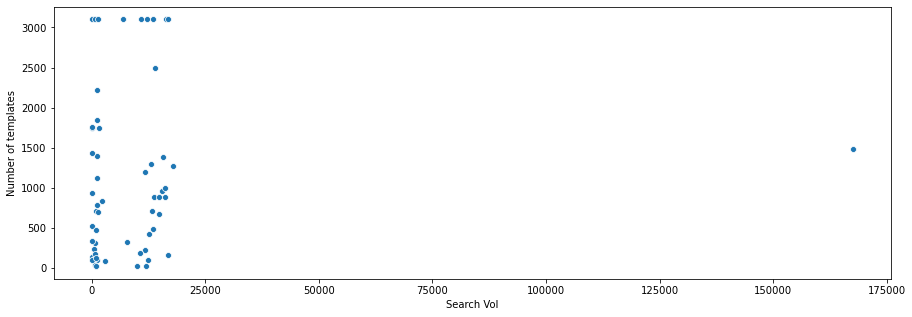

In [94]:
# Scatter plot to infere if it makes sense to calculate the fitted line
plt.figure(figsize=(15,5))

sns.scatterplot(data=trends_all_gp, 
                x=trends_all_gp['Search Vol'], 
                y=trends_all_gp['Number of templates']);

In [96]:
# See if there is a correlation between the two variables
trends_all_gp = sm.add_constant(trends_all_gp, has_constant='add')

# Run OLS
lin_reg = sm.OLS(trends_all_gp["Number of templates"],
                 trends_all_gp[["const", "Search Vol"]])

result = lin_reg.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Number of templates   R-squared:                       0.009
Model:                             OLS   Adj. R-squared:                 -0.009
Method:                  Least Squares   F-statistic:                    0.5013
Date:                 Thu, 09 Jul 2020   Prob (F-statistic):              0.482
Time:                         17:42:04   Log-Likelihood:                -492.73
No. Observations:                   59   AIC:                             989.5
Df Residuals:                       57   BIC:                             993.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1061.6088    147.821      7.182      0.000     765.602    1357.616
Search Vol     0.0044      0.006      0.708      0.482      -0.008       0.017
==============================================================================
Omnibus:                        8.433   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                9.014
Skew:                           0.934   Prob(JB):                       0.0110
Kurtosis:                       2.575   Cond. No.                     2.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

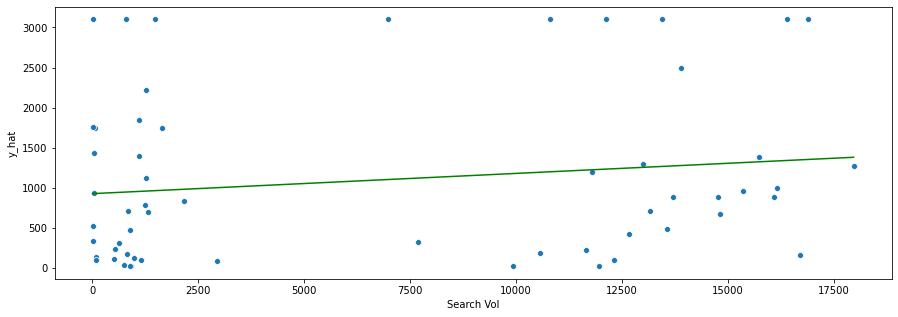

In [109]:
trends_all_gp = trends_all_gp.assign(y_hat=result.predict(trends_all_gp[["const", "Search Vol"]]))

plt.figure(figsize=(15,5))
    
sns.scatterplot(data=trends_all_gp, 
                x='Search Vol', 
                y='Number of templates');

sns.lineplot(data=trends_all_gp,
             x='Search Vol',
             y="y_hat",
             color="g");

That model is too affected by the 'Resume' outlier. I will try do the same process without the 'Document' category

In [110]:
trends_all_gp = trends_all_gp[trends_all_gp['Sub-category'] != 'Resume']

In [111]:
# See if there is a correlation between the two variables
trends_all_gp = sm.add_constant(trends_all_gp, has_constant='add')

# Run OLS
lin_reg = sm.OLS(trends_all_gp["Number of templates"],
                 trends_all_gp[["const", "Search Vol"]])

result = lin_reg.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Number of templates   R-squared:                       0.025
Model:                             OLS   Adj. R-squared:                  0.008
Method:                  Least Squares   F-statistic:                     1.444
Date:                 Thu, 09 Jul 2020   Prob (F-statistic):              0.235
Time:                         17:51:26   Log-Likelihood:                -484.32
No. Observations:                   58   AIC:                             972.6
Df Residuals:                       56   BIC:                             976.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        309.6564     65.110      4.756      0.000     179.226     440.086
const        309.6564     65.110      4.756      0.000     179.226     440.086
const        309.6564     65.110      4.756      0.000     179.226     440.086
Search Vol     0.0252      0.021      1.202      0.235      -0.017       0.067
==============================================================================
Omnibus:                        8.128   Durbin-Watson:                   2.325
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.499
Skew:                           0.904   Prob(JB):                       0.0143
Kurtosis:                       2.500   Cond. No.                     2.24e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.01e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

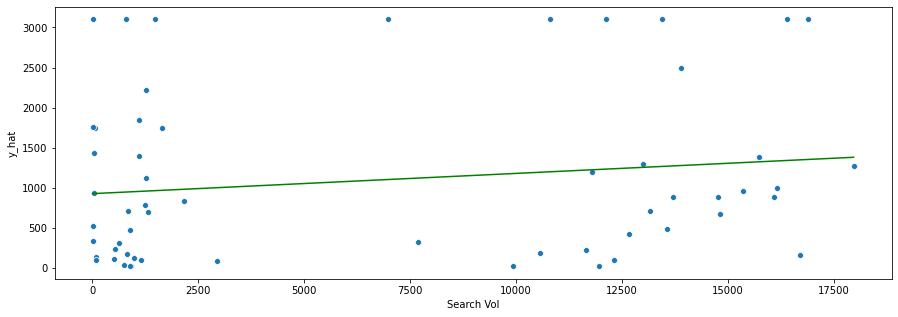

In [105]:
trends_all_gp = trends_all_gp.assign(y_hat=result.predict(trends_all_gp[["const", "Search Vol"]]))

plt.figure(figsize=(15,5))
    
sns.scatterplot(data=trends_all_gp, 
                x='Search Vol', 
                y='Number of templates');

sns.lineplot(data=trends_all_gp,
             x='Search Vol',
             y="y_hat",
             color="g");